# EDA

In [1]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.metrics.pairwise import haversine_distances, manhattan_distances

sys.path.insert(0, os.path.expanduser('./'))
import query_runner as qr
import utils

In [2]:
base_query_path = './queries/'
dwh_config, livedb_config, parameters_config = utils.load_config(config_file='./config.ini')
datalake_connection = qr.create_connection(db='datalake')
#monolith_connection = qr.create_connection(user=livedb_config['monolith_username'], password=livedb_config['monolith_password'], db='livedb')
#dispatching_db_connection = qr.create_connection(user=livedb_config['dispatching_db_username'], password=livedb_config['dispatching_db_password'], db='dispatchingdb')

In [3]:
start_date = parameters_config['start_date']
end_date = parameters_config['end_date']
country_code = parameters_config['country_code']

print(f'Start date: {start_date} | End date: {end_date} | Countries: {country_code}')

Start date: 2024-09-23 | End date: 2024-10-06 | Countries: ES


In [4]:
parameters = {
    'start_date': start_date,
    'end_date': end_date,
    'country_code': country_code
}

## Load the data

In [5]:
query_name = '''
SELECT
    olf.country_code                                 AS country_code,
    olf.city_code                                    AS city_code,
    olf.order_id                                     AS order_id,
    olf.courier_id                                   AS courier_id,
    olf.order_created_local_datetime                 AS creation_timestamp,
    olf.order_activated_local_datetime               AS activation_timestamp,
    olf.courier_transport                            AS transport,
    olf.order_picked_up_local_datetime               AS pickup_timestamp,
    olf.order_delivered_local_datetime               AS delivery_timestamp,
    olf.order_pickup_latitude                        AS pickup_latitude,
    olf.order_pickup_longitude                       AS pickup_longitude,
    olf.order_delivery_latitude                      AS delivery_latitude,
    olf.order_delivery_longitude                     AS delivery_longitude,
    olf.order_arrival_to_delivery_local_datetime     AS delivery_entering_timestamp,
    olf.order_time_zone                              AS time_zone,
    olf.p_creation_date
FROM delta.courier_routing_courier_ml_features_odp.order_level_features AS olf
WHERE order_final_status = 'DeliveredStatus'
    AND order_number_of_assignments = 1
    AND order_bundle_index IS NULL
    AND p_creation_date >= DATE '[start_date]' AND p_creation_date < DATE '[end_date]'
    AND country_code IN ('[country_code]')
'''

query = qr.Query(base_query_path, query_name, datalake_connection, parameters_dict=parameters, query_from_file = False)

df = query.run()
df = df.fillna(value=np.nan)

data = df.copy()
data.head()

Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/af5efdf105b33784feb4f433455a73219d17f7c01d2e86584ae01933ae48ab4c


,country_code,city_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_timestamp,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,delivery_entering_timestamp,time_zone,p_creation_date
0,ES,BCN,100907487116,8590944,2024-10-03 20:55:02+00:00,2024-10-03 20:55:04+00:00,BICYCLE,2024-10-03 21:21:44.215000+00:00,2024-10-03 21:32:33+00:00,41.370594,2.113433,41.375412,2.104837,2024-10-03 21:29:37+00:00,Europe/Madrid,2024-10-03
1,ES,MAD,100907489425,162535288,2024-10-03 20:55:43+00:00,2024-10-03 20:55:44+00:00,BICYCLE,2024-10-03 21:07:40.941000+00:00,2024-10-03 21:19:10+00:00,40.382927,-3.626392,40.383490,-3.640969,2024-10-03 21:16:09+00:00,Europe/Madrid,2024-10-03
2,ES,MGP,100907492383,167053666,2024-10-03 20:56:35+00:00,2024-10-03 20:56:36+00:00,MOTORBIKE,2024-10-03 21:06:13.285000+00:00,2024-10-03 21:12:51+00:00,39.528732,2.540573,39.538560,2.560975,2024-10-03 21:12:24+00:00,Europe/Madrid,2024-10-03
3,ES,BCN,100907493124,146788593,2024-10-03 20:56:48+00:00,2024-10-03 20:56:49+00:00,BICYCLE,2024-10-03 21:07:40.560000+00:00,2024-10-03 21:14:30+00:00,41.389874,2.159761,41.390520,2.148718,2024-10-03 21:12:00+00:00,Europe/Madrid,2024-10-03
4,ES,MAD,100907498582,45695767,2024-10-03 20:58:25+00:00,2024-10-03 20:58:26+00:00,MOTORBIKE,2024-10-03 21:08:59.224000+00:00,2024-10-03 21:14:21+00:00,40.409720,-3.670494,40.412880,-3.671840,2024-10-03 21:11:21+00:00,Europe/Madrid,2024-10-03


## Clean the dataset

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1536205 entries, 0 to 36204
Data columns (total 16 columns):
 #   Column                       Non-Null Count    Dtype              
---  ------                       --------------    -----              
 0   country_code                 1536205 non-null  object             
 1   city_code                    1536205 non-null  object             
 2   order_id                     1536205 non-null  int64              
 3   courier_id                   1536205 non-null  int64              
 4   creation_timestamp           1536205 non-null  datetime64[ns, UTC]
 5   activation_timestamp         1536205 non-null  datetime64[ns, UTC]
 6   transport                    1536205 non-null  object             
 7   pickup_timestamp             1535647 non-null  datetime64[ns, UTC]
 8   delivery_timestamp           1536205 non-null  datetime64[ns, UTC]
 9   pickup_latitude              1536205 non-null  float64            
 10  pickup_longitude         

In [7]:
data.describe()

,order_id,courier_id,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude
count,1.536205e+06,1.536205e+06,1.536205e+06,1.536205e+06,1.536205e+06,1.536205e+06
mean,1.008989e+11,1.308424e+08,3.979646e+01,-2.437437e+00,3.979665e+01,-2.437684e+00
std,8.173440e+06,5.069962e+07,3.270964e+00,4.486772e+00,3.270975e+00,4.486684e+00
min,1.008847e+11,1.160000e+04,2.773856e+01,-1.778775e+01,2.773566e+01,-1.779950e+01
25%,1.008919e+11,1.079144e+08,3.946703e+01,-3.810658e+00,3.946503e+01,-3.814944e+00
50%,1.008987e+11,1.549434e+08,4.046509e+01,-2.994206e+00,4.046810e+01,-2.994632e+00
75%,1.009062e+11,1.687019e+08,4.141026e+01,2.081995e+00,4.141481e+01,2.078547e+00
max,1.009129e+11,1.789302e+08,4.357925e+01,4.290346e+00,4.358983e+01,4.297597e+00


In [8]:
# Check for missing values
data.isnull().sum()

country_code                       0
city_code                          0
order_id                           0
courier_id                         0
creation_timestamp                 0
activation_timestamp               0
transport                          0
pickup_timestamp                 558
delivery_timestamp                 0
pickup_latitude                    0
pickup_longitude                   0
delivery_latitude                  0
delivery_longitude                 0
delivery_entering_timestamp    33946
time_zone                          0
p_creation_date                    0
dtype: int64

In [9]:
# Remove rows with null values: we have 1.5 M rows, so we can afford to remove them
data = data.dropna()

In [10]:
# Check for missing values
data.isnull().sum()

country_code                   0
city_code                      0
order_id                       0
courier_id                     0
creation_timestamp             0
activation_timestamp           0
transport                      0
pickup_timestamp               0
delivery_timestamp             0
pickup_latitude                0
pickup_longitude               0
delivery_latitude              0
delivery_longitude             0
delivery_entering_timestamp    0
time_zone                      0
p_creation_date                0
dtype: int64

In [11]:
# Check for duplicates
data.duplicated().sum()

np.int64(0)

## Compute new features

In [12]:
# Convert the creation time to datetime
data['creation_timestamp'] = pd.to_datetime(data['creation_timestamp'])
data['activation_timestamp'] = pd.to_datetime(data['activation_timestamp'])
data['pickup_timestamp'] = pd.to_datetime(data['pickup_timestamp'])
data['delivery_timestamp'] = pd.to_datetime(data['delivery_timestamp'])
data['delivery_entering_timestamp'] = pd.to_datetime(data['delivery_entering_timestamp'])

# Compute the delivery date and the delivery time
data['creation_date'] = data['creation_timestamp'].dt.date
data['creation_time'] = data['creation_timestamp'].dt.time
data['creation_hour'] = data['creation_timestamp'].dt.hour

In [13]:
# Compute the distance between the pickup and delivery points
data['pd_distance_haversine_m'] = data.apply(lambda x: haversine((x['pickup_latitude'], x['pickup_longitude']), (x['delivery_latitude'], x['delivery_longitude']), unit=Unit.METERS), axis=1)
data['pd_distance_haversine_m_sk'] = data.apply(lambda x: haversine_distances(np.array([[x['pickup_latitude'], x['pickup_longitude']]]), np.array([[x['delivery_latitude'], x['delivery_longitude']]])), axis=1)
data['pd_distance_manhattan_m'] = data.apply(lambda x: manhattan_distances(np.array([[x['pickup_latitude'], x['pickup_longitude']]]), np.array([[x['delivery_latitude'], x['delivery_longitude']]])), axis=1)
data.head()

,country_code,city_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_timestamp,pickup_latitude,...,delivery_latitude,delivery_longitude,delivery_entering_timestamp,time_zone,p_creation_date,creation_date,creation_time,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m
0,ES,BCN,100907487116,8590944,2024-10-03 20:55:02+00:00,2024-10-03 20:55:04+00:00,BICYCLE,2024-10-03 21:21:44.215000+00:00,2024-10-03 21:32:33+00:00,41.370594,...,41.375412,2.104837,2024-10-03 21:29:37+00:00,Europe/Madrid,2024-10-03,2024-10-03,20:55:02,895.267385,[[0.008835822216147426]],[[0.013414000000000481]]
1,ES,MAD,100907489425,162535288,2024-10-03 20:55:43+00:00,2024-10-03 20:55:44+00:00,BICYCLE,2024-10-03 21:07:40.941000+00:00,2024-10-03 21:19:10+00:00,40.382927,...,40.383490,-3.640969,2024-10-03 21:16:09+00:00,Europe/Madrid,2024-10-03,2024-10-03,20:55:43,1236.264251,[[0.013090010777783042]],[[0.01513999999999971]]
2,ES,MGP,100907492383,167053666,2024-10-03 20:56:35+00:00,2024-10-03 20:56:36+00:00,MOTORBIKE,2024-10-03 21:06:13.285000+00:00,2024-10-03 21:12:51+00:00,39.528732,...,39.538560,2.560975,2024-10-03 21:12:24+00:00,Europe/Madrid,2024-10-03,2024-10-03,20:56:35,2062.906211,[[0.011174379535681678]],[[0.030229999999998647]]
3,ES,BCN,100907493124,146788593,2024-10-03 20:56:48+00:00,2024-10-03 20:56:49+00:00,BICYCLE,2024-10-03 21:07:40.560000+00:00,2024-10-03 21:14:30+00:00,41.389874,...,41.390520,2.148718,2024-10-03 21:12:00+00:00,Europe/Madrid,2024-10-03,2024-10-03,20:56:48,924.017061,[[0.009439473750393588]],[[0.011689000000003169]]
4,ES,MAD,100907498582,45695767,2024-10-03 20:58:25+00:00,2024-10-03 20:58:26+00:00,MOTORBIKE,2024-10-03 21:08:59.224000+00:00,2024-10-03 21:14:21+00:00,40.409720,...,40.412880,-3.671840,2024-10-03 21:11:21+00:00,Europe/Madrid,2024-10-03,2024-10-03,20:58:25,369.394256,[[0.003388700168894049]],[[0.004506000000001009]]


## EDA

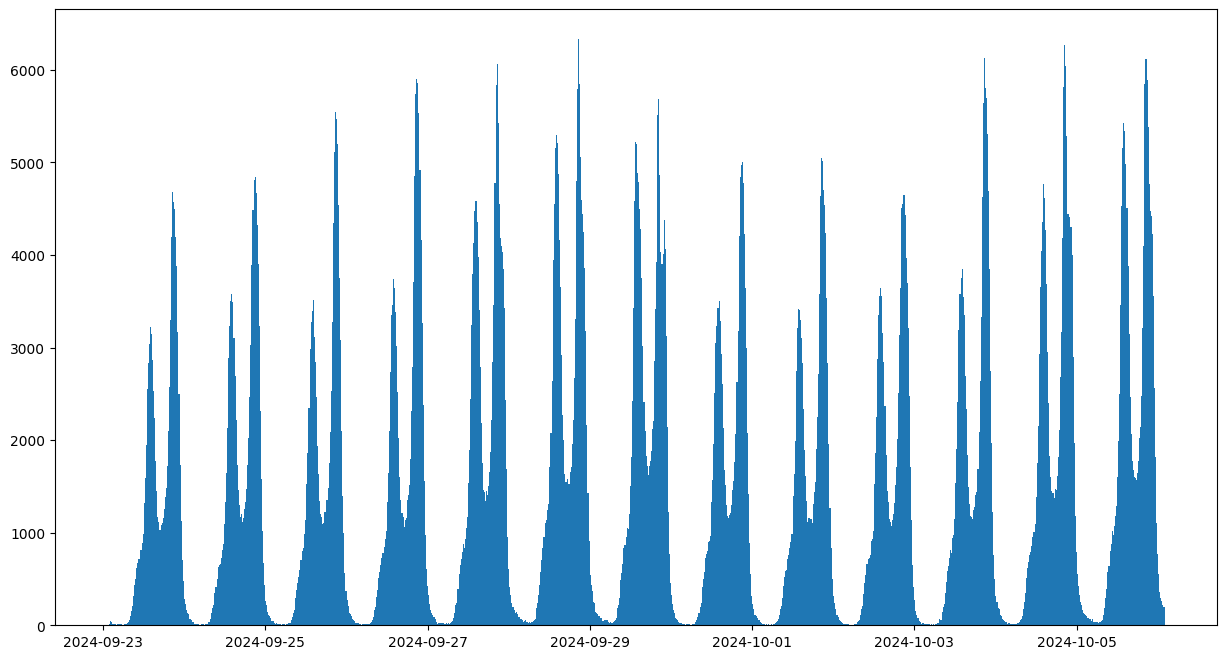

In [14]:
# Histogram of the # of data per day / hour
plt.figure(figsize=(15, 8))
plt.hist(data['creation_timestamp'], bins = 1000)
plt.show()

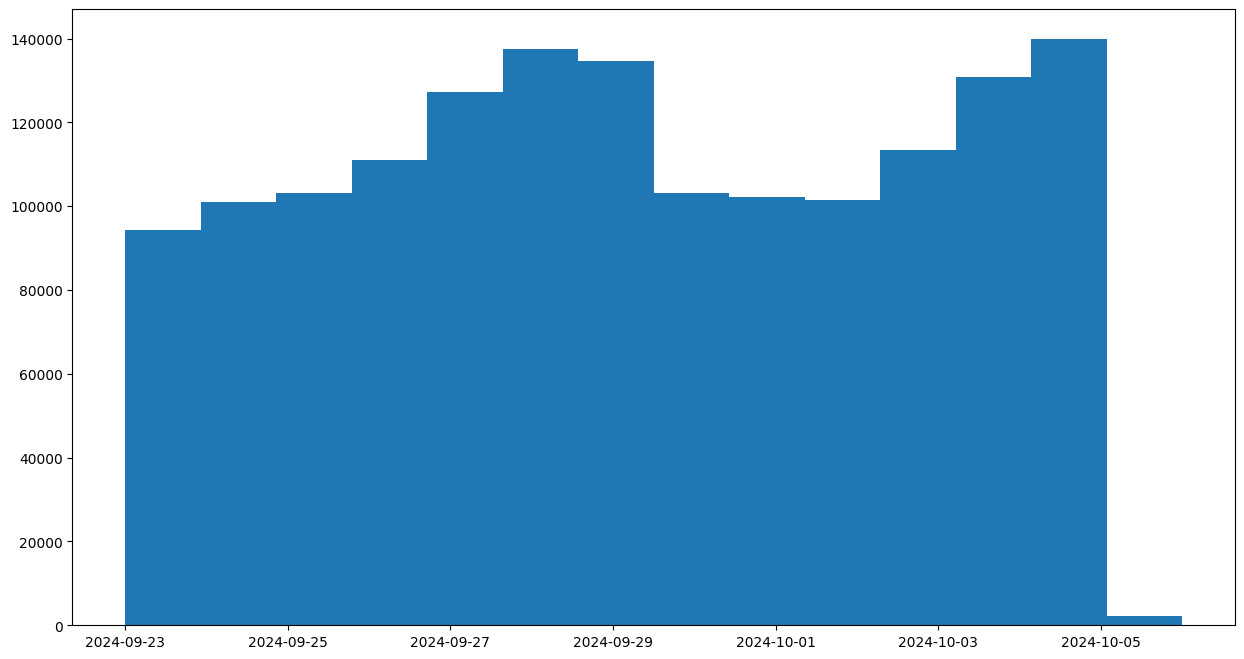

In [15]:
plt.figure(figsize=(15, 8))
plt.hist(data['creation_date'], bins = 14)
plt.show()

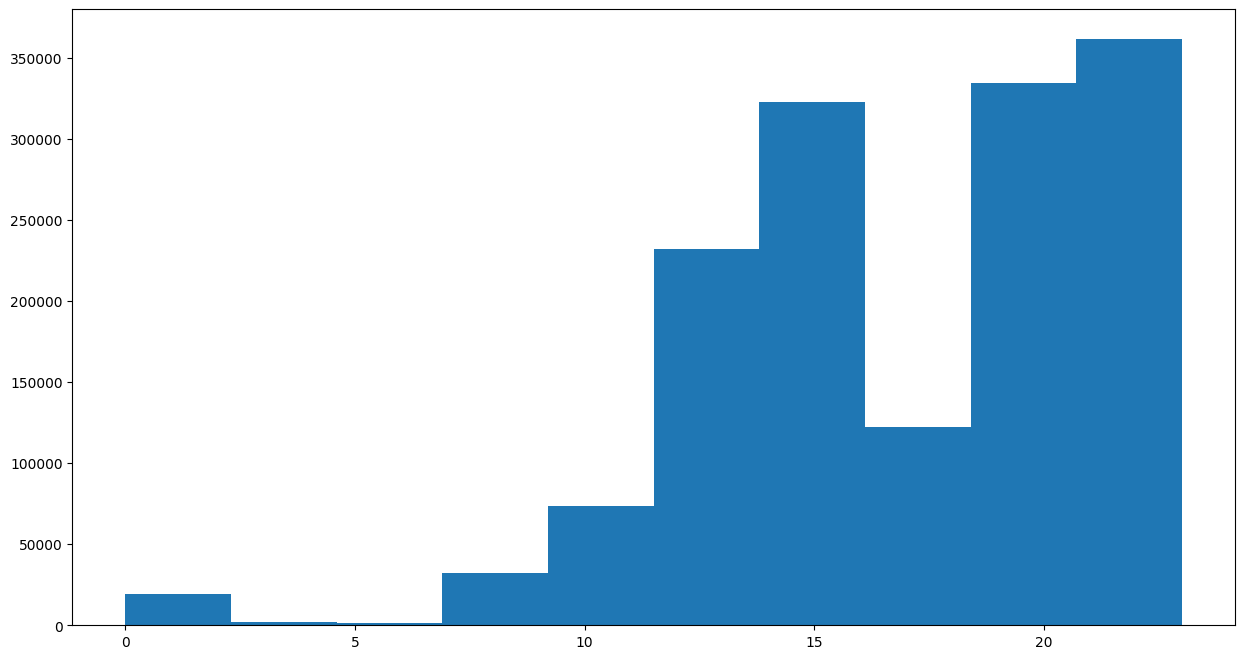

In [19]:
plt.figure(figsize=(15, 8))
plt.hist(data['creation_hour'])
plt.show()